### Imports

In [1]:
import boto3
import dask
import dilib
import os
import pathlib
import pytz
from collections import defaultdict
from datetime import datetime, timedelta
from typing import Any

import pandas as pd
import numpy as np
import rich

from epoch_data import athena
from epoch_data import calendarlib
from epoch_data import hdstorelib
from epoch_infra import commonlib
from epoch_infra import clusterlib
from epoch_infra import joblib
from epoch_markets import symlib
from epoch_markets.mdcatalog.options import data_config, instr_helper, job, job_config
from epoch_markets.symlib import options

from octopus import refdata_options
from octopus import datelib
from octopus import archives

### Helpers and Functions

In [2]:
def get_secmaster(path_prefix: str="/fsxcache/output") -> symlib.SecMaster:
    data_client = hdstorelib.MainDataClient(
        protocol="file",
        host=None,
        name_resolver=None,
        network_latency=None,
        path_prefix=path_prefix
    )

    fronts_factory = symlib.FrontsFactory(
        data_client=data_client,
        base_path="secdef",
        front_scheme="mft_rel",
        ignore_missing_products=True,
    )

    secmaster = symlib.SecMaster(
        data_client=data_client,
        base_path="secdef",
        fronts_factory=fronts_factory,        
    )

    return secmaster

secmaster = get_secmaster()


def get_mapping_from_gsym(gsym: str) -> symlib.InstrumentMapping:
    return symlib.InstrumentKey.get_instrument_mapping(gsym)


def get_futures(
    gsym: str,
    trade_date: datetime.date,
) -> list[symlib.Instrument]:
    res = set()
    for offset in range(1, 3):
        key = symlib.InstrumentKey(gsym, trade_date, offset)
        res.add(secmaster.get_instrument(key))
    return list(res)


def get_options(
    gsym: str,
    start_date: datetime.date,
    end_date: datetime.date,
    is_complex: bool,
) -> list[symlib.Instrument]:
    res = []
    for trade_date in calendar.get_date_range(
        start_date, end_date, isoweekdays={1, 2, 3, 4, 5}
    ):
        res.extend(instr_helper.get_options(gsym, trade_date, trade_date, 0, is_complex=is_complex, secmaster=secmaster))
    return list(set(res))


def get_exchange_symbols(
    gsym: str,
    trade_date: datetime.date,
    is_complex: bool,
) -> list[str]:
    ids = instr_helper.get_exchange_symbols_and_sec_ids(trade_date, trade_date, calendar, gsym, is_complex=is_complex, secmaster=secmaster)
    return [i.exchange_symbol for i in ids]


# read a book parquet file for some symbol
# e.g. data = client.gather(client.compute(dask.delayed(get_book_data)("03Tzyk", calendar.get_date(20230921, forward=True), version)))
def get_book_data(exchange: str, gsym: str, symbol: str, trade_date: calendarlib.TradeDate, version: str):
    # /{fsx_location}/books/cboe/2023/01/03/v5/{symbol}/book.parquet
    args = dict(exchange=exchange, year=trade_date.year, month=trade_date.month_padded, 
                day=trade_date.day_padded, version=version, symbol=symbol, gsym=gsym)
    if exchange == "cme":
        book_location = "/fsxcache/output/books/{exchange}/{gsym}/{year}/{month}/{day}/{version}/{symbol}"
    elif exchange == "cboe":
        book_location = "/fsxcache/output/books/{exchange}/{year}/{month}/{day}/{version}/{symbol}"
    elif exchange == "nymx":
        book_location = "/fsxcache/output/books/{exchange}/{year}/{month}/{day}/{version}/{symbol}"
    path = book_location.format(**args)
    print (path)
    files = ["book", "trades"]
    ret = {}
    for f in files:
        ret[f] = pd.read_parquet(f"{path}/{f}.parquet")
    return ret

def get_outright_1m_price_data_cache_hashes(trade_date: calendarlib.TradeDate, keys: list[symlib.OptionSpecificInstrumentKey]):
    data_context = athena.DataContext(read_namespaces=["prod"], write_namespace="prod")
    container = data_config.get_options_container(data_context=data_context)
    core_market_dataset = container.config.core_market_dataset
    res = {}
    for key in keys:
        if exchange == "cme":
            res[key.exchange_security_id] = core_market_dataset.get_outright_1m_price_data(key, version).cache_protocol.data_hash
        else:
            res[key.exchange_symbol] = core_market_dataset.get_outright_1m_price_data(key, version).cache_protocol.data_hash
        return res

def validate_cached_downsampled_files(gsym: str, trade_date: calendarlib.TradeDate, keys: list[symlib.OptionSpecificInstrumentKey]):
    res_list = []
    cache_hashes = get_outright_1m_price_data_cache_hashes(trade_date, keys)
    for exchange_symbol, cache_hash in cache_hashes.items():
        path = f"/fsxcache/output/prod/derived/options_core_market/v1/outright_1m_price_data/v0/{cache_hash}/{exchange_symbol}/{trade_date}.pickle"
        res = dict(symbol=exchange_symbol, date=trade_date, file_location=path)
        res[f"ds_file_exists"] = os.path.exists(path)
        res_list.append(res)
    return res_list

### Loading CH Refdata

In [3]:
with refdata_options.get_opt_refdata_dao(refdata_options.OptRefdataDao.TABLE_NAME_V2) as dao:
    ch_refdata = dao.get_all_refdata()

### Configuration

In [ ]:
# OESW Configuration
gsym = "OES"
base_asset = "OESW"
version = "v2.1"
is_complex = False
pcap_ch_table = 'historical.oes_1min_pcap_v1'
exchange = symlib.Exchanges.CME.name.lower()

In [4]:
data_context = athena.DataContext(read_namespaces=["test", "prod"], write_namespace="test")
container = data_config.get_options_container(data_context=data_context)
core_market_dataset = container.config.core_market_dataset
source_market_dataset = container.config.source_market_dataset

In [5]:
# the cboe stream and book jobs produce files based on a given day's 5 day range symbols (v5)
# cme streams (v2) do as well but the books (v2.1) are based on a given day's 1 day range symbols
gsym = "OES"
base_asset = "OESW"
version = "v2.1"
is_complex = False
pcap_ch_table = 'historical.oes_1min_pcap_v1'
exchange = symlib.Exchanges.CME.name.lower()
calendar = container.config.ref_data_config.cme_calendar if exchange == "cme" else container.config.ref_data_config.cboe_calendar
trade_date = calendar.get_date(20230802, forward=True)

In [6]:
checks = {
    'options_count': False,
    'timestamp_boundaries': False,
    'options': {}
}

### Getting Option Chain from secmaster

In [7]:
option_chain = get_options(gsym, trade_date, trade_date, False)

#### Check - Options Count

In [8]:
def check_options_count(d: datetime.date, base_asset:str, option_chain: list[symlib.Instrument], ch_refdata: pd.DataFrame):
    expiry_date = np.datetime64(d)
    oesw_refdata_options = ch_refdata[(ch_refdata.base_asset == base_asset) & (ch_refdata.expiry_date == expiry_date)]
    if len(oesw_refdata_options.index) == len(option_chain):
        print (f'CHECK - Options Count - SUCCESS ({len(option_chain)})')
        checks['options_count'] = True
    else:
        print ('CHECK - Options Count - ERROR')
        print(f'Refinitiv: {len(oesw_refdata_options.index)} - PCAP: {len(option_chain)})')
        raise Exception ('CHECK ERROR')   

In [9]:
check_options_count(trade_date, base_asset, option_chain, ch_refdata)
expiry_date = np.datetime64(trade_date)
refdata_options = ch_refdata[(ch_refdata.base_asset == base_asset) & (ch_refdata.expiry_date == expiry_date)]

CHECK - Options Count - SUCCESS (544)


### Getting Market Data

In [10]:
expiry_date = np.datetime64(trade_date)
refdata_options = ch_refdata[(ch_refdata.base_asset == base_asset) & (ch_refdata.expiry_date == expiry_date)]
times_begin = refdata_options.expiry_timestamp[0].replace(hour=0, minute=0, second=0).tz_localize('UTC')
times_end = refdata_options.expiry_timestamp[0].tz_localize('UTC')      

In [11]:
db_archives = archives.ClickArchive(pcap_ch_table)
pcap_df = (
            db_archives.load_symbols_between_times(
            symbols=refdata_options.symbol.unique(),
            begin=times_begin,
            end=times_end,
            columns=['ask', 'bid', 'mid', 'ask_size', 'bid_size'],
            )
        )

In [12]:
db_archives = archives.ClickArchive('historical.trthopt_1min_v7')
trth_df = (
            db_archives.load_symbols_between_times(
            symbols=refdata_options.symbol.unique(),
            begin=times_begin,
            end=times_end,
            columns=['ask', 'bid', 'mid', 'ask_size', 'bid_size'],
            )
        )

In [13]:
pcap_df.set_index(['timestamp'], drop=False, inplace=True)
pcap_df.sort_index(inplace=True)
trth_df.set_index(['timestamp'], drop=False, inplace=True)
trth_df.sort_index(inplace=True)

### Checking Market Data Timestamp boundaries

In [14]:
trth_min_timestamp = trth_df.timestamp.min()
trth_max_timestamp = trth_df.timestamp.max()
pcap_min_timestamp = pcap_df.timestamp.min()
pcap_max_timestamp = pcap_df.timestamp.max()
if trth_min_timestamp == pcap_min_timestamp and trth_max_timestamp == pcap_max_timestamp:
    print (f'CHECK - Timestamp boundaries - SUCCESS {trth_min_timestamp} -> {trth_max_timestamp}')
    checks['timestamp_boundaries'] = True
else:
    print ('CHECK - Timestamp boundaries - ERROR')
    print (f'Min Timestamp: trth:{trth_min_timestamp} pcap:{pcap_min_timestamp} equal:{trth_min_timestamp == pcap_min_timestamp}')
    print (f'Max Timestamp: trth:{trth_max_timestamp} pcap:{pcap_max_timestamp} equal:{trth_max_timestamp == pcap_max_timestamp}')
    raise Exception ('CHECK ERROR')   

CHECK - Timestamp boundaries - SUCCESS 2023-08-02 00:00:00+00:00 -> 2023-08-02 19:59:00+00:00


### Checking an option

In [15]:
def remove_missing_timestamps(sym_trth, sym_pcap):
    # Remove missing timestamps when refinitiv does not have them
    # This happens when the prices is the same between minutes
    # I am unsure if it is Refinitiv and Post Processing in MFT
    trth_index_missings = sym_pcap.index.difference(sym_trth.index)
    return sym_pcap.drop(trth_index_missings)

def remove_timestamps_with_nans(sym_trth, sym_pcap):
    nan_index = sym_pcap[(sym_pcap.bid.isna()) | (sym_pcap.ask.isna())].index
    sym_trth_temp = sym_trth.drop(nan_index)
    sym_pcap_temp = sym_pcap.drop(nan_index)
    nan_index = sym_trth_temp[(sym_trth_temp.bid.isna()) | (sym_trth_temp.ask.isna())].index
    sym_trth_final = sym_trth_temp.drop(nan_index)
    sym_pcap_final = sym_pcap_temp.drop(nan_index)
    return sym_trth_final, sym_pcap_final

def check_option(symbol: str):
    sym_trth = trth_df[(trth_df.symbol == symbol)]
    sym_pcap = pcap_df[(pcap_df.symbol == symbol)]

    # After investigation, we found that Refinitiv does not send any NaN / 0
    # We are going then to filter out these timestamps for the check between
    # pacp and trth.
    sym_pcap_filtered = remove_missing_timestamps(sym_trth, sym_pcap)
    sym_trth_filtered, sym_pcap_filtered = remove_timestamps_with_nans(sym_trth, sym_pcap_filtered)

    

    # Log how many timestamps we have a difference
    results = pd.DataFrame()
    results['bid'] = sym_trth_filtered.bid.ge(sym_pcap_filtered.bid) | np.isclose(sym_trth_filtered.bid, sym_pcap_filtered.bid)
    results['ask'] = sym_trth_filtered.bid.ge(sym_pcap_filtered.ask) | np.isclose(sym_trth_filtered.ask, sym_pcap_filtered.ask)
    issues = results[~results.bid| ~results.ask] 
    checks['options'][symbol] = (len(issues.index), issues)
    print(f'CHECK - Differences for {symbol} = {len(issues.index)}')

In [16]:
for symbol in refdata_options.symbol:
    check_option(symbol)

CHECK - Differences for EC1W1000H23 = 4
CHECK - Differences for EC1W1000T23 = 0
CHECK - Differences for EC1W100H23 = 3
CHECK - Differences for EC1W100T23 = 0
CHECK - Differences for EC1W1100H23 = 3
CHECK - Differences for EC1W1100T23 = 0
CHECK - Differences for EC1W1200H23 = 3
CHECK - Differences for EC1W1200T23 = 0
CHECK - Differences for EC1W1300H23 = 3
CHECK - Differences for EC1W1300T23 = 0
CHECK - Differences for EC1W1400H23 = 3
CHECK - Differences for EC1W1400T23 = 0
CHECK - Differences for EC1W1500H23 = 3
CHECK - Differences for EC1W1500T23 = 0
CHECK - Differences for EC1W1600H23 = 3
CHECK - Differences for EC1W1600T23 = 0
CHECK - Differences for EC1W1700H23 = 3
CHECK - Differences for EC1W1700T23 = 0
CHECK - Differences for EC1W1800H23 = 3
CHECK - Differences for EC1W1800T23 = 0
CHECK - Differences for EC1W1900H23 = 3
CHECK - Differences for EC1W1900T23 = 0
CHECK - Differences for EC1W2000H23 = 3
CHECK - Differences for EC1W2000T23 = 0
CHECK - Differences for EC1W2100H23 = 3
CH

### ARB Checks

#### Helpers

In [17]:
"""
Relatively standalone arb-checking tools for Zeno.

See the "Arb-Uniform" LP in Joel's Zeno notes for an explanation:
    http://mftshare/joel.gibson/notes_html/Zeno/Arbitrage%20in%20OSPXW%20and%20OESW.html
Although what is done here is slightly different in the treatment of the wings.
"""

from __future__ import annotations

import numpy as np
import scipy.optimize


def create_gross_payoff(strike: np.ndarray, pc_flag: np.ndarray):
    """
    Create a gross payoff matrix of shape (S, A), where S is the number of distrinct strikes in the
    problem, and gross_payoff[i, j] is the payoff of contract j at the ith strike.

    Input are two vectors of the same length A:
    - strike[i] is the strike price of the ith contract.
    - pc_flag[i] is 'C' for calls and 'P' for puts.
    """
    A = len(strike)
    assert strike.shape == pc_flag.shape == (A,)

    # The elbows are the sample points in price space.
    elbow = np.unique(strike)
    E = len(elbow)

    # Convert the put-call flag into +1 for calls, and -1 for puts.
    pc_sign = np.where(pc_flag == 'C', 1.0, -1.0)

    # The payoff matrix has shape (E, 2A), a horizontally-stacked matrix of [buy, sell].
    # The entry [e, a] is the payoff for buying the ath contract, if the underlying finishes at e.
    # The entry [e, A + a] is the payoff for selling.
    # Add a dummy column at the end for t.
    payoff = np.zeros((E, A), dtype=float)
    for i in range(A):
        payoff[:, i] = np.maximum(pc_sign[i] * (elbow - strike[i]), 0.0)

    return payoff


def arb_uniform(
    gross_payoff: np.ndarray,  # (S, A)
    pc_flag: np.ndarray,  # (A)
    bid: np.ndarray,  # (A)
    ask: np.ndarray,  # (A)
) -> tuple[float, np.ndarray, np.ndarray]:  # (1, (A), (A))
    """
    Check a collection of option prices (of length A) for arbitrage, at a single point in time.

    Inputs:
    - gross_payoff: Shape (S, A) representing payoffs at strikes.
    - pc_flag: Shape (A), either 'C' for call or 'P' for put.
    - bid, ask: Shape (A), bid and ask prices, or NaN if the price does not exist.

    Returns a pair (payoff, buy_weight, sell_weight) of the maximum uniform payoff (a scalar)
    achievable, and two shape (A) vectors of weights to use to buy/sell to achieve this payoff.
    If the payoff scalar is positive, there is an arbitrage.

    Usually one would expect there to be no cancellation in buy_weight - sell_weight, i.e. if we
    are buying something we don't sell it, and vice-versa. However, since we are forcing the buy
    and sell weights to collectively add to 1, sometimes we are forced to both buy and sell the same
    contract (especially in a dataset of only one contract)!.
    """
    S, A = gross_payoff.shape
    assert pc_flag.shape == bid.shape == ask.shape == (A,)
    assert np.all((pc_flag == 'C') | (pc_flag == 'P'))

    # Our linear program is the following:
    # Maximise min_payoff = [0 | 0 | 1] ⋅ [buy | sell | min_payoff]
    #   Over (2A + 1) variables:
    #                buy ≥ 0, of length A,
    #               sell ≥ 0, of length A,
    #         min_payoff ∈ ℝ, scalar
    #   With the constraints:
    #     L1 (S)  [ gross_payoff - 1 @ askᵀ | 1 @ bidᵀ - gross_payoff | -1 ] @ [buy | sell | t] ≥ 0
    #     L2 (1)  [ call_indicator          | - call_indicator        |  0 ] @ [buy | sell | t] ≥ 0
    #     L3 (1)  [ put_indicator           | - put_indicator         |  0 ] @ [buy | sell | t] ≥ 0
    #     E4 (1)  [ 1 1 1 1 1 1 1 1 1 1 1 1 | 1 1 1 1 1 1 1 1 1 1 1 1 |  0 ] @ [buy | sell | t] = 1
    #
    # Constraint L1 is saying that net_payoff(buy, sell) evaluated at the strike k is ≥ t, for all
    # strikes k. Since the objective is to maximise t, this means at any optimal solution t will be
    # the minimum net payoff at any strike. Constraint L2 says that the gradient of the payoff curve
    # after the largest strike is zero or positive (this gradient is the net weight of calls).
    # Similarly, constraint L3 says that the gradient on the left of the smallest strike is
    # negative, i.e. increases to the left. Finally, constraint E4 forces the weights to sum to 1.
    #
    # There are other details:
    # 1. scipy.optimise.linprog wants to accept a constraint like L @ x ≤ b rather than L @ x ≥ b.
    #    So we end up negating our L matrix.
    # 2. scipy.optimise.linprog wants to minimise instead of maximise. So we negate our objective
    #    vector, and negate the final value of the program as well.
    # 2. Buy variables (and corresponding constraint columns) where the ask are NaN are removed
    #    entirely from the problem, and similarly for missing bid prices.
    #
    # Since buy, sell ≥ 0 and constraint E4, the buy and sell variables are bounded. Hence t is also
    # bounded provided there is at least one nonzero column in L1. If all bids and asks are NaN,
    # then t will be unbounded. So we should early return from this case. Any buy and sell in bounds
    # can be extended to a feasible point by taking t low enough, so the LP is always feasible.

    # Mask of variables: only present buys, present sells, and always t.
    mask = np.concatenate([~np.isnan(ask), ~np.isnan(bid), [True]])
    if mask[:2*A].sum() == 0:
        return 0.0, np.zeros(A, dtype=float), np.zeros(A, dtype=float)

    # Objective function
    obj = np.zeros(2 * A + 1, dtype=float)
    obj[-1] = 1

    # We could construct this a bit at a time or as a block matrix and both ways are gross...
    L = np.zeros((S + 2, 2 * A + 1), dtype=float)

    # L1
    L[0:S, 0:A] += gross_payoff
    L[0:S, 0:A] -= ask
    L[0:S, A:2*A] -= gross_payoff
    L[0:S, A:2*A] += bid
    L[0:S, -1] = -1.0

    # L2
    L[S, 0:A] = np.where(pc_flag == 'C', 1.0, 0.0)
    L[S, A:2*A] = np.where(pc_flag == 'C', -1.0, 0.0)

    # L3
    L[S+1, 0:A] = np.where(pc_flag == 'P', 1.0, 0.0)
    L[S+1, A:2*A] = np.where(pc_flag == 'P', -1.0, 0.0)

    # E4
    E = np.zeros((1, 2 * A + 1))
    E[:, 0:2*A] = 1

    # Run the solver. We disable the presolve since our constraint matrix is small and interesting
    # enough that it can never reduce the problem anyway. (I think the rows are positively indep
    # and so there is no reduction to be done). Unfortunately Scipy will convert this to a sparse
    # matrix and then give it to HiGHS even though it's dense...
    result = scipy.optimize.linprog(
        c=-obj[mask],
        A_ub=-L[:, mask],
        b_ub=np.zeros(S + 2, dtype=float),
        A_eq=E[:, mask],
        b_eq=np.array([1.0]),
        bounds=[(0, None)] * mask[:2*A].sum() + [(None, None)],
        options=dict(presolve=False),
        method='highs-ds',
    )

    # Since the problem is bounded and feasible, this should always succeed.
    assert result.success

    # Unpack the weights from the mask.
    weight = np.zeros(2*A, dtype=float)
    weight[mask[:-1]] = result.x[:-1]

    return -result.fun, weight[:A], weight[A:]

In [18]:
from __future__ import annotations

import pytest
import dataclasses

import numpy as np
import numpy.testing




@dataclasses.dataclass
class OptData:
    pc: str
    strike: float
    bid: float
    ask: float


@pytest.mark.parametrize('insts, expected_payoff', [
    # A one-sided call: the only possible move is to buy it.
    ([OptData('C', 1000.0, np.nan, 3.0)], -3.0),

    # A two-sided call: the best move is to buy half and sell half.
    # (Can't sell more than we buy, else the payoff curve becomes negative somewhere).
    ([OptData('C', 1000.0, 1.0, 3.0)], -1.0),

    # A call and a put at the same strike. These should be independent, so same result as before.
    ([OptData('C', 1000.0, 1.0, 3.0), OptData('P', 1000.0, 1.0, 3.0)], -1.0),

    # Two calls with a short call spread giving an arb. The best choice is to sell the first and
    # buy the second, for a uniform payoff of
    #   Bid(1000) - Ask(1000) - (1020 - 1000) = (23 - 2) - 20 = 1.0
    # Since weights sum to 1, this will be a payoff of 0.5 here.
    ([OptData('C', 1000.0, 23.0, 24.0), OptData('C', 1020.0, 1.0, 2.0)], 0.5),

    # If the first call is worth a little less, the short call spread is not an arb.
    ([OptData('C', 1000.0, 21.0, 24.0), OptData('C', 1020.0, 1.0, 2.0)], -0.5),
])
def test_arb_uniform_option(insts: list[OptData], expected_payoff: float):
    strike = np.array([inst.strike for inst in insts], dtype='float')
    pc_flag = np.array([inst.pc for inst in insts])
    bid = np.array([inst.bid for inst in insts], dtype='float')
    ask = np.array([inst.ask for inst in insts], dtype='float')

    gross_payoff = zeno.arb.create_gross_payoff(strike, pc_flag)
    payoff, buy, sell = zeno.arb.arb_uniform(gross_payoff, pc_flag, bid, ask)

    numpy.testing.assert_allclose(payoff, expected_payoff)
    assert np.all(buy >= 0)
    assert np.all(sell >= 0)
    numpy.testing.assert_allclose(buy.sum() + sell.sum(), 1.0)


#### Test

In [19]:
opt_symbols = refdata_options.symbol.unique()
point_values = numpy.array([*list(refdata_options.loc[opt_symbols, 'point_value'])])
pcf = numpy.array([*list(refdata_options.loc[opt_symbols, 'pc'])])
strikes = numpy.array([*list(refdata_options.loc[opt_symbols, 'strike_price'])])
gross_payoff = create_gross_payoff(strikes, pcf)

In [20]:
def get_payoffs(data, opt_symbols, times, gross_payoff):
    mkt_data = {
        col: numpy.array(
            [
                *[
                    data[opt][col].to_numpy()
                    if opt in data
                    else numpy.full(len(times), numpy.nan)
                    for opt in opt_symbols
                ]
            ]
        ).T
        for col in ['ask', 'mid', 'bid', 'ask_size', 'bid_size']
    }
    results = []
    for idx in range(0, len(times)):
        payoff, buy, sell = arb_uniform(gross_payoff, pcf, mkt_data['bid'][idx], mkt_data['ask'][idx])
        results.append(payoff)
    return results

In [21]:
import pandas as pd

times = pd.date_range(times_begin, times_end, inclusive='left', freq='1T', name='datetime')
trth_data = {
    symbol: frame.drop('symbol', axis='columns').set_index('timestamp').reindex(times)
    for symbol, frame in trth_df.groupby('symbol', sort=False)
}
pcap_data = {
    symbol: frame.drop('symbol', axis='columns').set_index('timestamp').reindex(times)
    for symbol, frame in pcap_df.groupby('symbol', sort=False)
}
trth_results = get_payoffs(trth_data, opt_symbols, times, gross_payoff)
pcap_results = get_payoffs(pcap_data, opt_symbols, times, gross_payoff)

In [22]:
results = pd.DataFrame(
    {'TRTH': trth_results,
     'PCAP': pcap_results
    }, index=times)

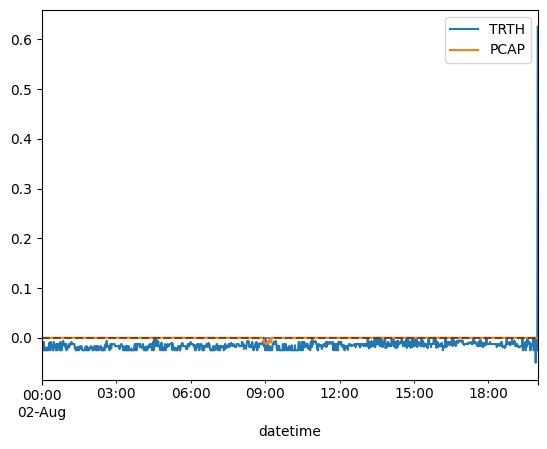

In [23]:
ax = results.plot()
ax.axhline(0, ls='--', color='black', alpha=0.5)

In [24]:
print (results[results.TRTH > 1.e-6].TRTH)

datetime
2023-08-02 19:59:00+00:00    0.625
Freq: T, Name: TRTH, dtype: float64


In [25]:
print (results[results.PCAP > 1.e-6].PCAP)

Series([], Freq: T, Name: PCAP, dtype: float64)


In [26]:
print (results[results.PCAP > 0].PCAP)

datetime
2023-08-02 00:12:00+00:00    5.026500e-15
2023-08-02 00:17:00+00:00    2.266016e-15
2023-08-02 00:19:00+00:00    3.974912e-15
2023-08-02 00:23:00+00:00    2.016209e-14
2023-08-02 00:24:00+00:00    9.115170e-16
                                 ...     
2023-08-02 19:30:00+00:00    9.860168e-15
2023-08-02 19:35:00+00:00    5.928591e-16
2023-08-02 19:40:00+00:00    3.345825e-15
2023-08-02 19:58:00+00:00    1.140988e-14
2023-08-02 19:59:00+00:00    1.798561e-14
Name: PCAP, Length: 209, dtype: float64


In [44]:
trth_neg      = trth_df[(trth_df.bid < 0) | (trth_df.ask < 0)]
trth_no_nan   = trth_df.dropna()
trth_in_cross = trth_no_nan[trth_no_nan.bid >= trth_no_nan.ask]
print(trth_neg)
print(trth_in_cross)

Empty DataFrame
Columns: [symbol, timestamp, ask, bid, mid, ask_size, bid_size]
Index: []
Empty DataFrame
Columns: [symbol, timestamp, ask, bid, mid, ask_size, bid_size]
Index: []


In [65]:
pcap_neg      = pcap_df[(pcap_df.bid < 0) | (pcap_df.ask < 0)]
pcap_no_nan   = pcap_df.dropna()
pcap_in_cross = pcap_no_nan[pcap_no_nan.bid >= pcap_no_nan.ask]
print(pcap_neg)
print(pcap_in_cross)

Empty DataFrame
Columns: [symbol, timestamp, ask, bid, mid, ask_size, bid_size]
Index: []
                                symbol                 timestamp   ask   bid  \
timestamp                                                                      
2023-08-02 00:22:00+00:00  EC1W4390T23 2023-08-02 00:22:00+00:00  0.05  0.05   
2023-08-02 00:23:00+00:00  EC1W4390T23 2023-08-02 00:23:00+00:00  0.05  0.05   
2023-08-02 00:24:00+00:00  EC1W4390T23 2023-08-02 00:24:00+00:00  0.05  0.05   
2023-08-02 00:25:00+00:00  EC1W4390T23 2023-08-02 00:25:00+00:00  0.05  0.05   
2023-08-02 00:26:00+00:00  EC1W4390T23 2023-08-02 00:26:00+00:00  0.05  0.05   
...                                ...                       ...   ...   ...   
2023-08-02 19:54:00+00:00  EC1W4390T23 2023-08-02 19:54:00+00:00  0.05  0.05   
2023-08-02 19:55:00+00:00  EC1W4390T23 2023-08-02 19:55:00+00:00  0.05  0.05   
2023-08-02 19:56:00+00:00  EC1W4390T23 2023-08-02 19:56:00+00:00  0.05  0.05   
2023-08-02 19:57:00+00:00  EC1

### Deep diving one option

In [46]:
option_to_deep_dive = 'EC1W4390T23'

In [47]:
option_refdata = refdata_options[refdata_options.symbol == option_to_deep_dive]
assert len(option_refdata.index) == 1
option_refdata = option_refdata.squeeze(axis=0)

In [48]:
option_strike = int(option_refdata.strike_price)
put_or_call = options.PutOrCall.Call if option_refdata.pc == 'C' else options.PutOrCall.Put
for option in option_chain:
    if int(option.strike_price) == option_strike and option.put_or_call == put_or_call:
        option_key = option.instrument_key
        break
assert option_key

In [56]:
cache = validate_cached_downsampled_files('OES', trade_date, [option_key])
rich.print(cache)
exchange_symbol = cache[0]['symbol']

[
    {
        'symbol': 4188688,
        'date': 20230802,
        'file_location': 
'/fsxcache/output/prod/derived/options_core_market/v1/outright_1m_price_data/v0/667c8652/4188688/20230802.pickle',
        'ds_file_exists': False
    }
]

In [68]:
data = get_book_data(exchange, gsym, exchange_symbol, trade_date, version)

/fsxcache/output/books/cme/OES/2023/08/02/v2.1/4188688


ArrowInvalid: Could not open Parquet input source '<Buffer>': Parquet file size is 0 bytes

In [32]:
d = pd.DataFrame.from_dict(data['book'])

In [33]:
option_check_results = checks['options'][option_to_deep_dive][1]

In [34]:
option_check_results

bid    ask
timestamp                              
2023-08-02 03:40:00+00:00   True  False
2023-08-02 09:47:00+00:00  False  False
2023-08-02 12:00:00+00:00   True  False
2023-08-02 14:08:00+00:00  False  False
2023-08-02 14:26:00+00:00  False  False
2023-08-02 16:37:00+00:00   True  False
2023-08-02 17:29:00+00:00  False   True
2023-08-02 17:32:00+00:00  False   True
2023-08-02 18:27:00+00:00  False   True
2023-08-02 19:14:00+00:00   True  False
2023-08-02 19:41:00+00:00  False  False

In [35]:
for time_to_inspect in option_check_results.index:
    # Left labelled - 08:07 is last price before 08:08
    start_time = time_to_inspect
    end_time = time_to_inspect + pd.Timedelta(minutes=1)
    #print (start_time.timestamp(), end_time.timestamp())
    print (f'Inpecting time {time_to_inspect}')
    print('Difference')
    rich.print(f'Refinitiv: {trth_df[trth_df.symbol == option_to_deep_dive].loc[time_to_inspect][["ask", "bid"]]}')
    rich.print(f'Pcap: {pcap_df[pcap_df.symbol == option_to_deep_dive].loc[time_to_inspect][["ask", "bid"]]}')

    print ('Raw data in parquet file')
    option_raw_data = d[(d.ts / 1000000000 >= start_time.timestamp()) & (d.ts /1000000000 < end_time.timestamp())]
    if len(option_raw_data.index) > 5:
        rich.print(option_raw_data.iloc[-5:][['ts', 'offer_0', 'bid_0']])
    else:
        rich.print(option_raw_data[['ts', 'offer_0', 'bid_0']])
    print ('---------------------')

Inpecting time 2023-08-02 03:40:00+00:00
Difference


Refinitiv: ask    161.5
bid    160.5
Name: 2023-08-02 03:40:00+00:00, dtype: object

Pcap: ask    161.25
bid     160.5
Name: 2023-08-02 03:40:00+00:00, dtype: object

Raw data in parquet file


ts         offer_0           bid_0
3877  1690947611227236123  16150000000000  16050000000000
3878  1690947611231540322  16150000000000  16050000000000
3879  1690947611233554823  16150000000000  16050000000000
3880  1690947659995304844  16125000000000  16050000000000
3881  1690947659998039275  16125000000000  16050000000000

---------------------
Inpecting time 2023-08-02 09:47:00+00:00
Difference


Refinitiv: ask     146.0
bid    144.75
Name: 2023-08-02 09:47:00+00:00, dtype: object

Pcap: ask    145.75
bid     145.0
Name: 2023-08-02 09:47:00+00:00, dtype: object

Raw data in parquet file


ts         offer_0           bid_0
13371  1690969666532255755  14550000000000  14500000000000
13372  1690969668958782240  14550000000000  14475000000000
13373  1690969679924486553  14575000000000  14475000000000
13374  1690969679967947524  14600000000000  14475000000000
13375  1690969679981892792  14575000000000  14500000000000

---------------------
Inpecting time 2023-08-02 12:00:00+00:00
Difference


Refinitiv: ask    159.0
bid    158.0
Name: 2023-08-02 12:00:00+00:00, dtype: object

Pcap: ask    158.75
bid     158.0
Name: 2023-08-02 12:00:00+00:00, dtype: object

Raw data in parquet file


ts         offer_0           bid_0
18194  1690977652512144811  15900000000000  15800000000000
18195  1690977652522642877  15900000000000  15800000000000
18196  1690977659838932174  15900000000000  15800000000000
18197  1690977659981365554  15875000000000  15800000000000
18198  1690977659996427985  15875000000000  15800000000000

---------------------
Inpecting time 2023-08-02 14:08:00+00:00
Difference


Refinitiv: ask    137.75
bid    136.75
Name: 2023-08-02 14:08:00+00:00, dtype: object

Pcap: ask    137.5
bid    137.0
Name: 2023-08-02 14:08:00+00:00, dtype: object

Raw data in parquet file


ts         offer_0           bid_0
53848  1690985339914736751  13775000000000  13675000000000
53849  1690985339956092617  13775000000000  13675000000000
53850  1690985339987654022  13775000000000  13675000000000
53851  1690985339989425501  13750000000000  13700000000000
53852  1690985339994677272  13750000000000  13700000000000

---------------------
Inpecting time 2023-08-02 14:26:00+00:00
Difference


Refinitiv: ask    138.5
bid    129.5
Name: 2023-08-02 14:26:00+00:00, dtype: object

Pcap: ask     138.0
bid    137.25
Name: 2023-08-02 14:26:00+00:00, dtype: object

Raw data in parquet file


ts         offer_0           bid_0
67087  1690986419837566231  13825000000000  13725000000000
67088  1690986419847782722  13850000000000  13725000000000
67089  1690986419879539972  13850000000000  13700000000000
67090  1690986419973808896  13850000000000  12950000000000
67091  1690986419999559114  13800000000000  13725000000000

---------------------
Inpecting time 2023-08-02 16:37:00+00:00
Difference


Refinitiv: ask    124.25
bid     123.5
Name: 2023-08-02 16:37:00+00:00, dtype: object

Pcap: ask    124.0
bid    123.5
Name: 2023-08-02 16:37:00+00:00, dtype: object

Raw data in parquet file


ts         offer_0           bid_0
133006  1690994279760272545  12475000000000  12350000000000
133007  1690994279770694835  12475000000000  12350000000000
133008  1690994279864000871  12425000000000  12350000000000
133009  1690994279902795045  12425000000000  12350000000000
133010  1690994279967739796  12400000000000  12350000000000

---------------------
Inpecting time 2023-08-02 17:29:00+00:00
Difference


Refinitiv: ask    126.75
bid     124.0
Name: 2023-08-02 17:29:00+00:00, dtype: object

Pcap: ask    126.75
bid     125.0
Name: 2023-08-02 17:29:00+00:00, dtype: object

Raw data in parquet file


ts         offer_0           bid_0
150200  1690997399807971225  12625000000000  11725000000000
150201  1690997399814919212  12625000000000  11725000000000
150202  1690997399960349292  12625000000000  12400000000000
150203  1690997399973802246  12675000000000  12400000000000
150204  1690997399996857156  12675000000000  12500000000000

---------------------
Inpecting time 2023-08-02 17:32:00+00:00
Difference


Refinitiv: ask     128.0
bid    126.75
Name: 2023-08-02 17:32:00+00:00, dtype: object

Pcap: ask    128.0
bid    127.5
Name: 2023-08-02 17:32:00+00:00, dtype: object

Raw data in parquet file


ts         offer_0           bid_0
152112  1690997579921387496  12800000000000  12675000000000
152113  1690997579950381779  12800000000000  12675000000000
152114  1690997579953879715  12800000000000  12750000000000
152115  1690997579967932023  12800000000000  12750000000000
152116  1690997579983537928  12800000000000  12750000000000

---------------------
Inpecting time 2023-08-02 18:27:00+00:00
Difference


Refinitiv: ask     122.5
bid    120.75
Name: 2023-08-02 18:27:00+00:00, dtype: object

Pcap: ask    122.5
bid    121.0
Name: 2023-08-02 18:27:00+00:00, dtype: object

Raw data in parquet file


ts         offer_0           bid_0
168956  1691000879458927695  12225000000000  12075000000000
168957  1691000879472158487  12250000000000  12075000000000
168958  1691000879630140779  12250000000000  12075000000000
168959  1691000879850986756  12250000000000  12075000000000
168960  1691000879994288859  12250000000000  12100000000000

---------------------
Inpecting time 2023-08-02 19:14:00+00:00
Difference


Refinitiv: ask     117.0
bid    115.25
Name: 2023-08-02 19:14:00+00:00, dtype: object

Pcap: ask    124.25
bid    115.25
Name: 2023-08-02 19:14:00+00:00, dtype: object

Raw data in parquet file


ts         offer_0           bid_0
182031  1691003697405242995  11675000000000  11525000000000
182032  1691003697406394149  11675000000000  11525000000000
182033  1691003697448438628  11675000000000  11525000000000
182034  1691003699877383502  11700000000000  11525000000000
182035  1691003699977740587  12425000000000  11525000000000

---------------------
Inpecting time 2023-08-02 19:41:00+00:00
Difference


Refinitiv: ask    112.5
bid    112.0
Name: 2023-08-02 19:41:00+00:00, dtype: object

Pcap: ask    112.75
bid    112.25
Name: 2023-08-02 19:41:00+00:00, dtype: object

Raw data in parquet file


ts         offer_0           bid_0
190979  1691005319776264722               0  11125000000000
190980  1691005319799546395  11400000000000  11125000000000
190981  1691005319822484903               0  11125000000000
190982  1691005319946019411  11250000000000  11200000000000
190983  1691005319959172270  11275000000000  11225000000000

---------------------


### Useful code

In [36]:
# Left labelled - 08:07 is last price before 08:08
start_time = pd.Timestamp(f"2023-08-02 00:01:00+00:00")
end_time = pd.Timestamp(f"2023-08-02 00:02:00+00:00")
print (start_time.timestamp(), end_time.timestamp())

1690934460.0 1690934520.0


In [37]:
d[(d.ts / 1000000000 >= start_time.timestamp()) & (d.ts /1000000000 < end_time.timestamp())]

ts  feed_sequence  last_trade_sequence  \
950   1690934460310060388      315255358                   -1   
951   1690934460370959755      315256312                   -1   
952   1690934460426835257      315257582                   -1   
953   1690934460710878530      315262683                   -1   
954   1690934461487112865      315266213                   -1   
955   1690934461816394792      315269413                   -1   
956   1690934461836985143      315269842                   -1   
957   1690934461859094056      315270581                   -1   
958   1690934461917680357      315272116                   -1   
959   1690934461924068609      315272210                   -1   
960   1690934462595383326      315273834                   -1   
961   1690934462597434805      315273851                   -1   
962   1690934462603829418      315274032                   -1   
963   1690934462626727156      315274542                   -1   
964   1690934462638765667      315274863                   -1   
965   1690934462814147179      315275424                   -1   
966   1690934462829562224      315275492                   -1   
967   1690934462876940732      315275757                   -1   
968   1690934462884109060      315275958                   -1   
969   1690934463263147587      315276583                   -1   
970   1690934463296140389      315277144                   -1   
971   1690934463305583491      315277515                   -1   
972   1690934463307144776      315277576                   -1   
973   1690934464507295312      315281730                   -1   
974   1690934467082883220      315286139                   -1   
975   1690934467230872737      315286296                   -1   
976   1690934467232913631      315286339                   -1   
977   1690934467275782147      315287157                   -1   
978   1690934470100455157      315292364                   -1   
979   1690934470129764461      315292772                   -1   
980   1690934470136782606      315293000                   -1   
981   1690934470223206950      315293298                   -1   
982   1690934474168784554      315296189                   -1   
983   1690934475928871970      315297677                   -1   
984   1690934475955650255      315298060                   -1   
985   1690934475964078639      315298308                   -1   
986   1690934490065451110      315311085                   -1   
987   1690934497161932212      315312089                   -1   
988   1690934497191591678      315312469                   -1   
989   1690934497221253859      315313183                   -1   
990   1690934497303521958      315313713                   -1   
991   1690934498092803017      315314626                   -1   
992   1690934498117862534      315314997                   -1   
993   1690934498134023134      315315481                   -1   
994   1690934499186681153      315317050                   -1   
995   1690934499188756819      315317076                   -1   
996   1690934499198416606      315317266                   -1   
997   1690934499232853213      315317803                   -1   
998   1690934500692300993      315318880                   -1   
999   1690934500727065161      315319447                   -1   
1000  1690934508208268245      315322867                   -1   
1001  1690934508211095768      315322951                   -1   
1002  1690934513557456953      315324618                   -1   
1003  1690934517672948377      315327059                   -1   
1004  1690934517673977899      315327094                   -1   
1005  1690934517715918313      315327745                   -1   
1006  1690934517735975255      315328346                   -1   

                exch_time  latency  bookUpdateHadTrade         offer_0  \
950   1690934460301180047        0                   0  16650000000000   
951   1690934460301470933        0                   0  16625000000000   
952   1690934460301837881     

### Unused code

In [38]:
def check_option_toto(strike: int, put_or_call: options.PutOrCall, option_chain: list[symlib.Instrument]):
    option_key = None
    for option in option_chain:
        if int(option.strike_price) == option_strike and option.put_or_call == put_or_call:
            option_key = option.instrument_key
            break
        
    if not option_key:
        raise Exception(f'Cannot find option with strike:{strike} type:{put_or_call}')

In [39]:
# output locations, dependent on how the FSX cache was mounted
fsx_base_path = "/fsxcache/output"
old_fsx_base_path = "/fsxcache/old_output"
secdef_base_path = fsx_base_path

# /{fsx_location}/secdef/cboe/2023/01/SPX.20230101.secdef.json.gz
if exchange == "cme":
    secdef_location = secdef_base_path + "/secdef/{year}/{month}/{security_group}.{year}{month}{day}.secdef.json.gz"
elif exchange == "cboe":
    secdef_location = secdef_base_path + "/secdef/cboe/{year}/{month}/{security_group}.{year}{month}{day}.secdef.json.gz"

# /{fsx_location}/stream/cboe/outright/2023/01/03/v5/34/20230103.direct.gz
if exchange == "cme":
    stream_base_location = fsx_base_path + "/stream/{exchange}/{gsym}/{type_identifier}/{year}/{month}/{day}/{version}/{channel_identifier}"
    stream_location = stream_base_location + "/{year}{month}{day}.direct.gz"
elif exchange == "cboe":
    stream_base_location = old_fsx_base_path + "/stream/{exchange}/{type_identifier}/{year}/{month}/{day}/{version}/{channel_identifier}"
    stream_location = stream_base_location + "/{year}{month}{day}.direct.gz"
    
# /{fsx_location}/books/cboe/2023/08/01/v5/03PHfG/book.parquet
if exchange == "cme":
    book_location = fsx_base_path + "/books/{exchange}/{gsym}/{year}/{month}/{day}/{version}/{symbol}"
elif exchange == "cboe":
    book_location = old_fsx_base_path + "/books/{exchange}/{year}/{month}/{day}/{version}/{symbol}"
elif exchange == "nymx":
    book_location = fsx_base_path + "/books/{exchange}/{year}/{month}/{day}/{version}/{symbol}"

type_identifier = "complex" if is_complex else "outright"
channel_by_gsym = {
    "OSPX": 33,
    "OSPXW": 34,
    "OES": 311,
    "OS0": 313,
    "OTY": 345,
    "OCL": 383,
    "ONQ": 319,
    "ORTY": 319,
    "ONG": 387,
    # "OG": 361,
    "OC": 341,
    "OS": 341,
}

In [40]:
# setup query for the data validation

# cboe data available from 20220423-20230930
# public holidays: 20230101-2

start_date = 20230802
end_date = 20230802
gsyms = ["OES"] #, "OS0", "OTY", "OCL", "ONG", "ONQ", "ORTY", "OC", "OS"]
